# Imports

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import math
import pandas as pd
from astropy.timeseries import LombScargle

import os # Operating system interfaces
import sys

# Exoplanet data packages
import lightkurve as lk
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

# Dynamic nested sampling
import dynesty
from dynesty import NestedSampler, DynamicNestedSampler
from dynesty import plotting as dyplot

# MCMC sampling
import emcee
import corner
from multiprocessing import Pool
import h5py

# Library of custom functions
import TESSPhaseCurve_lib as TPC

# Matplotlib settings
# from matplotlib import font_manager
# font_dir = ['/home/paiasnodkar.1/fonts'] # This will not work for you since it is a local directory on my system
# for font in font_manager.findSystemFonts(font_dir):
#     font_manager.fontManager.addfont(font)

fontweight = 300
# plt.rcParams['font.family'] = 'monospace'
# plt.rcParams['font.monospace'] = ['Mulish']
plt.rcParams["font.weight"] = fontweight
plt.rcParams['axes.labelweight'] = 1.3*fontweight
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['axes.titlesize'] = 22

In [190]:
import importlib
importlib.reload(TPC)

<module 'TESSPhaseCurve_lib' from 'C:\\Users\\lucas\\TESSPhaseCurves\\TESSPhaseCurve_lib.py'>

# Read in data

Reference:  <a refstr=KOKORI_ET_AL__2023 href=https://ui.adsabs.harvard.edu/abs/2023ApJS..265....4K/abstract target=ref>Kokori et al. 2023</a>
Transit duration reference:  <a refstr=TRIAUD_ET_AL__2010 href=https://ui.adsabs.harvard.edu/abs/2010A&A...524A..25T/abstract target=ref>Triaud et al. 2010</a>
Period:  0.941452417 d +/-  1.9e-08 d
t_0:  2458501.324483 d +/-  1.9e-05 d
Transit duration:  2.18136 h


C:\Users\lucas\TESSPhaseCurves\TESSPhaseCurve_lib.py:192: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
  lc_fold.time_copy = np.copy(lc_fold.time)


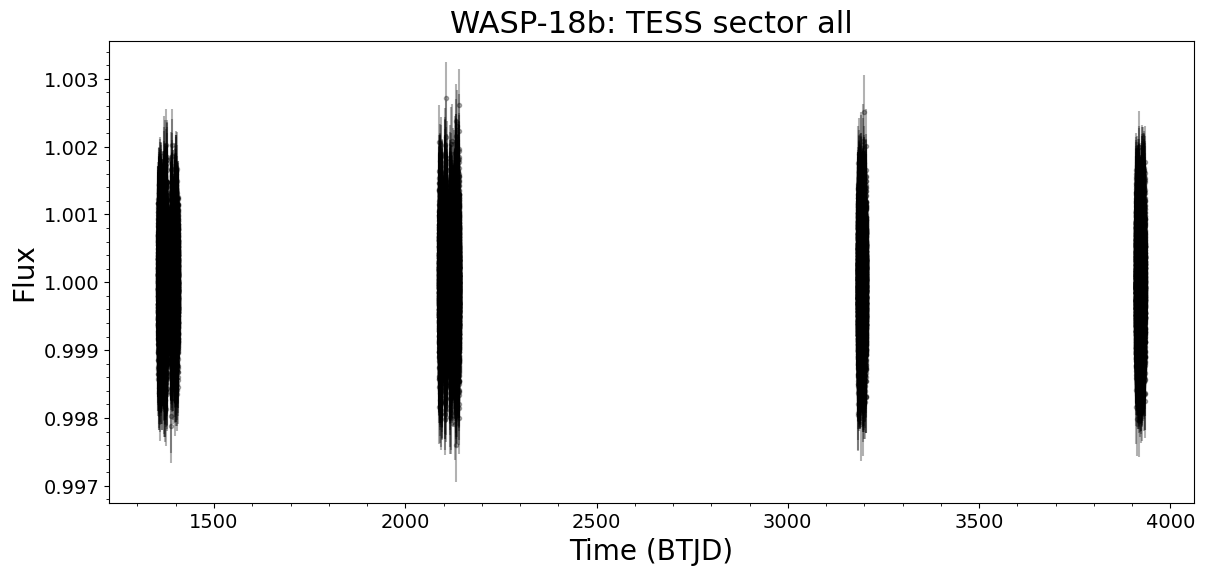

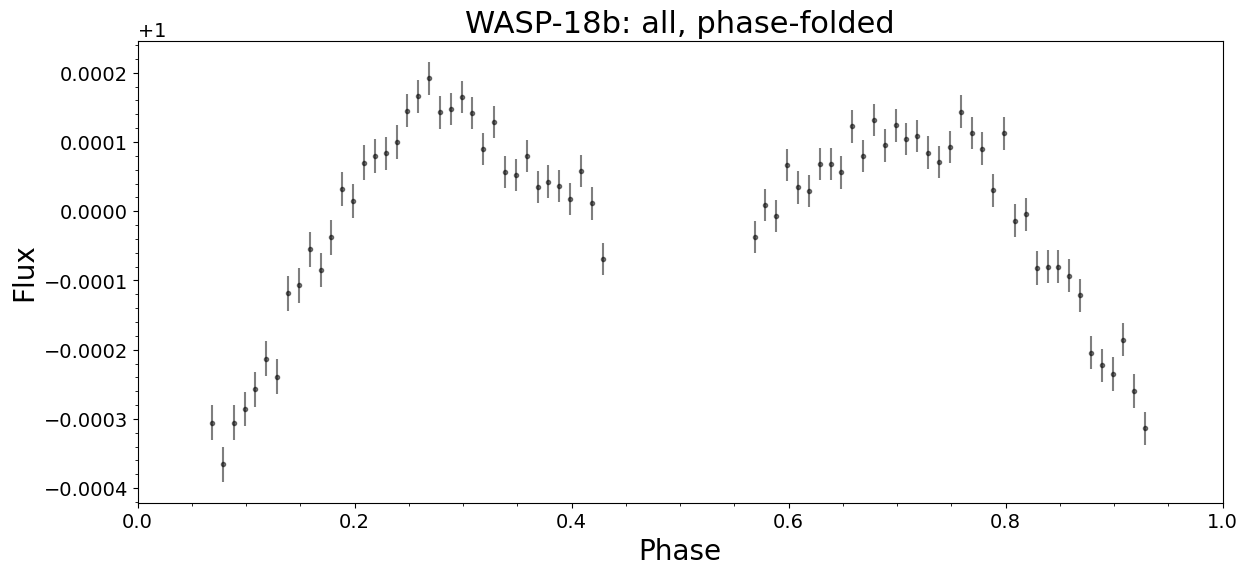

Successfully loaded  WASP-18b  parameter table from  C:\Users\lucas\TESSPhaseCurves/Model Fitting/WASP-18b Fitting/WASP-18b Parameters.xlsx  into dataframe.


In [170]:
planet_name = 'WASP-18b'
df = pd.read_csv('lightcurves 2/'+planet_name.replace(" ", "")+' 2.csv', comment='#', header=0)
sectors = np.unique(df.sector)
sector_ind = 'all' # set between 0 and len(sectors) to select an individual sector, set to 'all' for all sectors

if sector_ind == 'all':
    sector = 'all'
    time = np.array(df.time)
    flux = np.array(df.flux)
    flux_raw = np.array(df.flux_raw)
    flux_err = np.array(df.flux_err)
else:
    sector = sectors[sector_ind]
    sector_bool = df.sector == sector
    time = np.array(df.time)[sector_bool]
    flux = np.array(df.flux)[sector_bool]
    flux_raw = np.array(df.flux_raw)[sector_bool]
    flux_err = np.array(df.flux_err)[sector_bool]        

# Store data as a Lightkurve object to make it easier for phase-folding
lc_data = {'time': time,
           'flux': flux,
           'flux_err': flux_err
          }
lc_data = lk.LightCurve(lc_data)

NEA_result = NasaExoplanetArchive.query_object(planet_name)
TIC_id = NEA_result['tic_id'][0] # extracts the TESS Input Catalog ID number associated with the planet

# get index of source with least error in P
ephemeris_ind = None
avg_P_err_list = []
for i in range(len(NEA_result['pl_refname'])):
    avg_P_err = (abs(NEA_result['pl_orbpererr1'][i]) + abs(NEA_result['pl_orbpererr2'][i]))/2.
    avg_P_err_list.append(avg_P_err.value)
ephemeris_ind = avg_P_err_list.index(np.nanmin(avg_P_err_list)) # finds the index of the minimum average P_err value

# get index of the first source with a value for t_dur
t_dur_ind = None
for i in range(len(NEA_result['pl_refname'])):
    t_dur_test = NEA_result['pl_trandur'][i]
    if not math.isnan(t_dur_test.value):
        t_dur_ind = i
        break

# Extract orbital period (P), mid-transit time (t_0), and transit duration (t_dur)
P, t_0, t_dur = NEA_result['pl_orbper'][ephemeris_ind], NEA_result['pl_tranmid'][ephemeris_ind], \
NEA_result['pl_trandur'][t_dur_ind].value*u.hour
P_err = (abs(NEA_result['pl_orbpererr1'][ephemeris_ind]) + abs(NEA_result['pl_orbpererr2'][ephemeris_ind]))/2.
t_0_err = (abs(NEA_result['pl_tranmiderr1'][ephemeris_ind]) + abs(NEA_result['pl_tranmiderr1'][ephemeris_ind]))/2.
print('Reference: ', NEA_result['pl_refname'][ephemeris_ind])
print('Transit duration reference: ', NEA_result['pl_refname'][t_dur_ind])
print('Period: ', P, '+/- ', P_err)
print('t_0: ', t_0, '+/- ', t_0_err)
print('Transit duration: ', t_dur)
t_0 = t_0 - 2457000.0*u.day

bin_width = 0.01 * u.day
lc_data_fold = TPC.fold_lk(lc_data, P, t_0)
lc_data_bin = lc_data_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)
mask = lc_data_bin.flux_err > np.nanmean(lc_data_bin.flux_err) + 3*np.nanstd(lc_data_bin.flux_err)
lc_data_bin = lc_data_bin[~mask]

# Plot lightcurve
plt.figure(figsize=(14,6))
plt.errorbar(time, flux, flux_err, fmt='.', color='k', alpha=0.3)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': TESS sector '+str(sector))
plt.show()

# Plot phase-folded lightcurve
plt.figure(figsize=(14,6))
plt.errorbar(lc_data_bin.time.value, lc_data_bin.flux.value, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.xlim(0, 1)
plt.title(planet_name+': '+sector+', phase-folded')
plt.show()

# Initialize parameter table for planet
parent_path = sys.path[0]
fit_dir = "/Model Fitting/"+planet_name.replace(" ", "")+" Fitting/"
parent_dir = parent_path+fit_dir
overlay_figs = "Model Overlays/"
corner_figs = "Corner Plots/"
overlay_dir = parent_dir+overlay_figs
corner_dir = parent_dir+corner_figs
os.makedirs(parent_dir, exist_ok=True)
os.makedirs(overlay_dir, exist_ok=True)
os.makedirs(corner_dir, exist_ok=True)

excel_file_path = parent_dir+planet_name.replace(" ", "")+" Parameters.xlsx"
model_type = "NoPulse NoA1"

# # Do this section when making a new sheet and for each new planet
# table_labels = [r'$t_0$', r'$t_0 +1\sigma$', r'$t_0 -1\sigma$', 
#                 r'$P$', r'$P +1\sigma$', r'$P -1\sigma$', 
#                 r'$f_p$', r'$f_p +1\sigma$', r'$f_p -1\sigma$', 
#                 r'$\delta$', r'$\delta +1\sigma$', r'$\delta -1\sigma$', 
#                 r'$B_1$', r'$B_1 +1\sigma$', r'$B_1 -1\sigma$', 
#                 r'$A_2$', r'$A_2 +1\sigma$', r'$A_2 -1\sigma$', 
#                 r'$B_2$', r'$B_2 +1\sigma$', r'$B_2 -1\sigma$', 
#                 r'$A_3$', r'$A_3 +1\sigma$', r'$A_3 -1\sigma$', 
#                 r'$B_3$', r'$B_3 +1\sigma$', r'$B_3 -1\sigma$', 
#                 r'$\chi^2$', r'$BIC$', r'$max n$', r'$Converged?$']
# planet_table = pd.DataFrame(columns = table_labels)
# with pd.ExcelWriter(excel_file_path, engine="openpyxl", mode="a") as writer:
#     planet_table.to_excel(writer, sheet_name=model_type, header=table_labels, index=False)

planet_table = pd.read_excel(excel_file_path, sheet_name=model_type) # comment this out when making new sheet
print("Successfully loaded ", planet_name, " parameter table from ", excel_file_path, " into dataframe.")

# Model-fitting

Set up Bayesian framework

Define model, likelihood function arguments, and prior transform function arguments

In [161]:
### Likelihood function ###
def psi_tot_noPulse_noA1(params, t):
    t_0, P, fp, delta, B1, A2, B2, A3, B3 = params
    return TPC.psi_tot_no_pulse(t, t_0, P, fp, delta, 0, B1, A2, B2, A3, B3)

def psi_tot_noA1(params, t):
    t_0, P, PI, alpha, beta, fp, delta, B1, A2, B2, A3, B3 = params
    return TPC.psi_tot(t, t_0, P, PI, alpha, beta, fp, delta, 0, B1, A2, B2, A3, B3)

def chisq_model(data, model, data_err, d):
    return np.nansum(((data - model)**2)/(data_err**2))/(len(data)-d)

def bic(d, n, lnL):
    return (d * np.log(n)) - (2 * lnL)

In [171]:
# Names of all the model parameters
labels = [r'$t_0$', r'$P$', r'$f_p$', r'$\delta$',
          r'$B_1$', r'$A_2$', r'$B_2$', r'$A_3$', r'$B_3$']
ndim = len(labels) # number of model parameters


# Define an array of booleans that describe whether the priors will be uniform (True) or Gaussian (False) in order
priors_bool = np.array([True]*ndim)
priors_bool[0:2] = np.array([False]*2) # Setting the first two parameters to have Gaussian priors

# Define pairs of values that describe the priors for each parameter in order
priors = np.array([[t_0.value, 1*t_0_err.value], # t_0, Gaussian prior from Exoplanet Archive
                   [P.value, 1*P_err.value], # P, Gaussian prior from Exoplanet Archive
                   [-0.01, 0.01], # f_p, uniform prior
                   [-np.pi/4, np.pi/4], # delta, uniform prior
                   [-5e-4, 1e-4], # B_1, uniform prior
                   [-5e-4, 5e-4], # A_2, uniform prior
                   [-5e-4, 5e-4], # B_2, uniform prior
                   [-5e-4, 5e-4], # A_3, uniform prior
                   [-5e-4, 5e-4]]) # B_3, uniform prior

### Perform MCMC sampling with $\texttt{emcee}$

In [176]:
max_n = 20001 # maximum number of iterations to run for

filename_root = parent_dir+''.join(planet_name.split()) # filename at which to save progress

is_converged = False
initial = [t_0.value, P.value, -0.000341, 0, -0.000174, -0.000004, -0.000190, -0.000014, -0.000004] # Initial parameter guess

nwalkers = 2*ndim + 1
pos = np.array(initial) + (np.random.randn(nwalkers, 9) * np.transpose(np.array([[0.05 * t_0_err.value], # t_0 starting positions spread
                                                                                  [0.05 * P_err.value], # P starting positions spread
                                                                                  [0.9e-2], # f_p starting positions spread
                                                                                  [np.pi/8], # delta starting positions spread
                                                                                  [1e-4], # B_1 starting positions spread
                                                                                  [2e-4], # A_2 starting positions spread
                                                                                  [2e-4], # B_2 starting positions spread
                                                                                  [2e-4], # A_3 starting positions spread
                                                                                  [2e-4]]))) # B_3 starting positions spread

backend = emcee.backends.HDFBackend(filename_root+'_sampling.h5', name=''.join(planet_name.split())+'_sector'+str(sector)+'_'+model_type+'_'+str(max_n))
print("Planet backend file updated!")
backend.reset(nwalkers, ndim)
# with Pool() as pool:
sampler = emcee.EnsembleSampler(nwalkers, ndim, TPC.logPosterior,
                                args=(priors, priors_bool, lc_data.time.value, lc_data.flux.value, lc_data.flux_err.value, psi_tot_noPulse_noA1),
                                backend=backend)                                   
#                                    pool=pool)

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(pos, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    tau_nofp = np.delete(tau, 2)
    autocorr[index] = np.mean(tau_nofp)
    index += 1

    # Check convergence
    converged = np.all(tau_nofp * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau_nofp) / tau_nofp < 0.01)
    if converged:
        is_converged = True
        break # break out of loop if convergence criteria are met
    old_tau = tau_nofp

# Plot distributions and fit
np.set_printoptions(suppress=True)
lnprob = sampler.get_log_prob()
lnprob_flat = sampler.get_log_prob(flat=True)
chain = sampler.get_chain(flat=True, discard=200)
params_best = np.percentile(chain, 50, axis=0)
params_lower = np.percentile(chain, 16, axis=0)
params_upper = np.percentile(chain, 84, axis=0)
params_err_minus = []
params_err_plus = []
for i in range(len(labels)):
    params_err_minus.append(params_lower[i] - params_best[i])
    params_err_plus.append(params_upper[i] - params_best[i])

# make a list of each parameter's value, upper limit 1sig uncertainty, and lower limit 1sig uncertainty
params_with_err = []
for a, b, c in zip(params_best, params_err_plus, params_err_minus):
        params_with_err.append(a)
        params_with_err.append(b)
        params_with_err.append(c)
print('Best: ', params_best)

Planet backend file updated!


  0%|                                                                                          | 0/20001 [00:00<?, ?it/s]C:\Users\lucas\anaconda3\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  0%|▍                                                                               | 100/20001 [00:15<49:00,  6.77it/s]C:\Users\lucas\anaconda3\Lib\site-packages\emcee\autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]
 73%|█████████████████████████████████████████████████████████▎                    | 14700/20001 [40:14<14:30,  6.09it/s]


Best:  [1501.324483      0.94145242    0.00021224    0.01306396   -0.00016719
   -0.00000447   -0.00012564   -0.00001928   -0.00001127]


Plot parameter value vs iteration

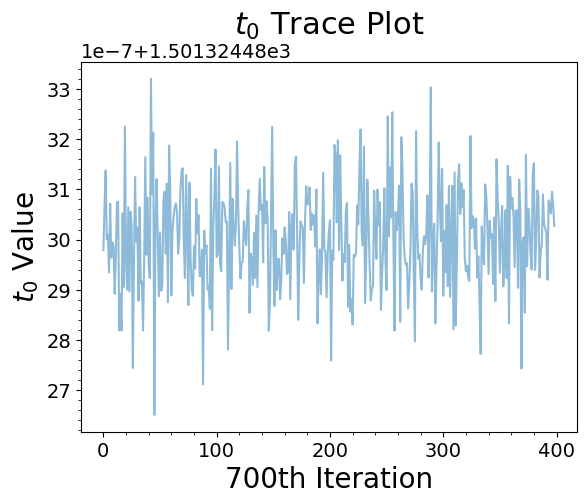

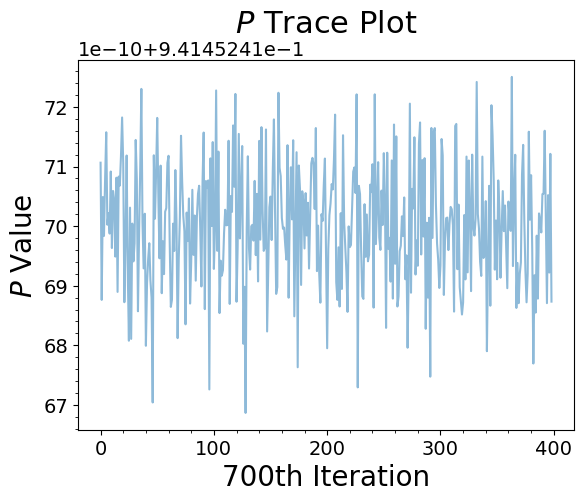

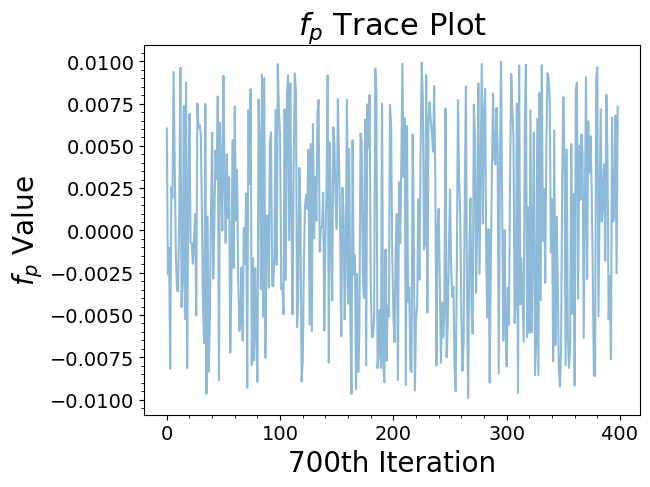

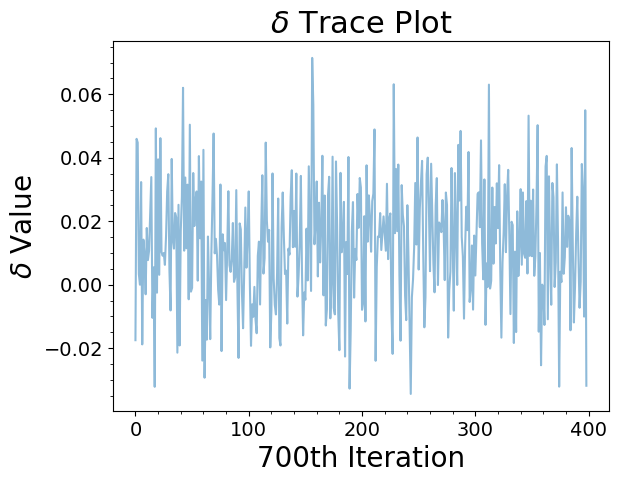

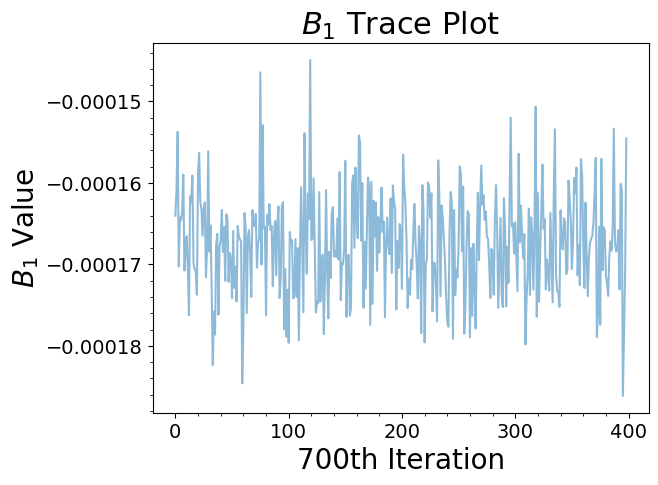

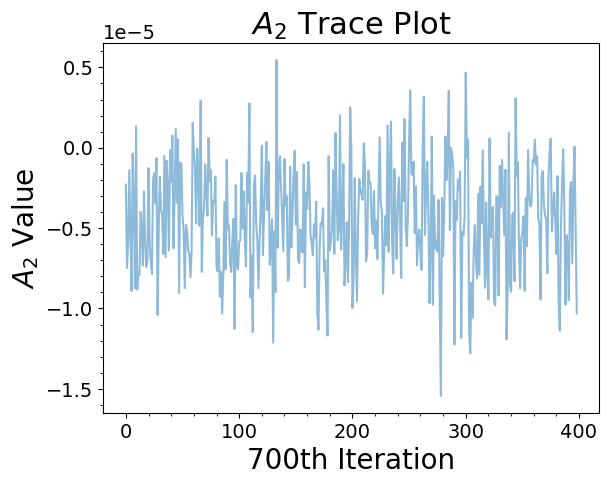

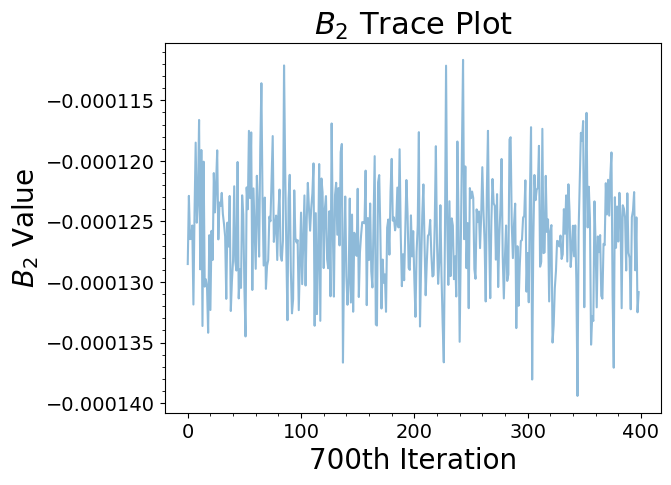

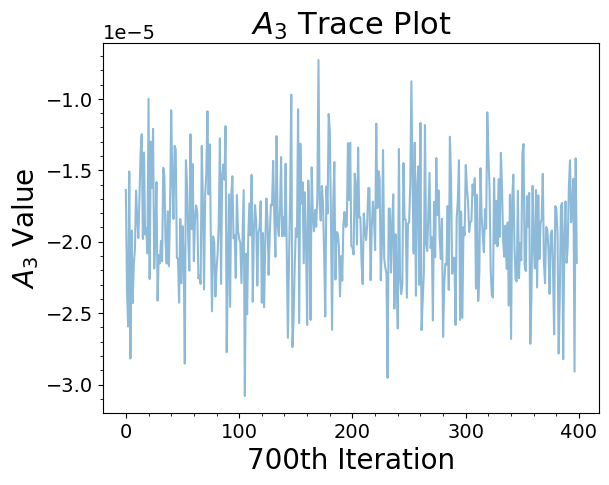

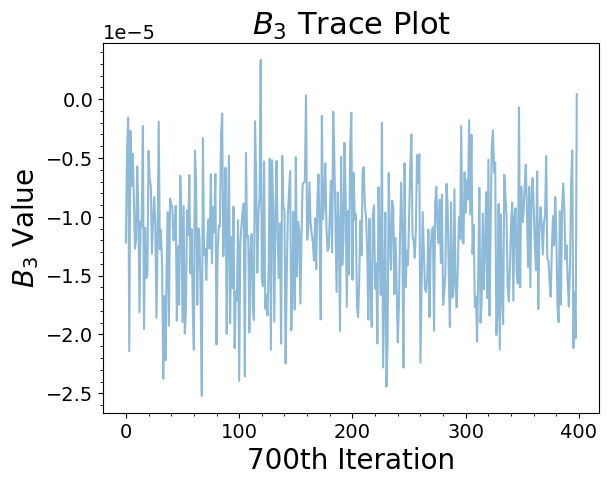

In [177]:
thinned = 700

# # use the following to read in backend file
# planet_name = 'KELT-9b'
# sector = 'all'
# max_n = 14000
# reader = emcee.backends.HDFBackend(filename_root+'_sampling.h5', name=join(planet_name.split())+'_sector'+str(sector)+'_'+model_type+'_'+str(max_n))
# chain = reader.get_chain(flat=True, thin=thinned, discard=0) # use if loading backend file

chain = sampler.get_chain(flat=True, thin=thinned, discard=0) # comment this out if using backend file
for i in range(chain.shape[1]): # Iterate through each parameter
    plt.figure()
    plt.plot(chain[:, i], alpha=0.5) # Plot all walkers for the current parameter
    plt.xlabel(str(thinned)+"th Iteration")
    plt.ylabel(f"{labels[i]} Value")
    plt.title(f"{labels[i]} Trace Plot")
    plt.show()

Plot corner plot of posterior distribution

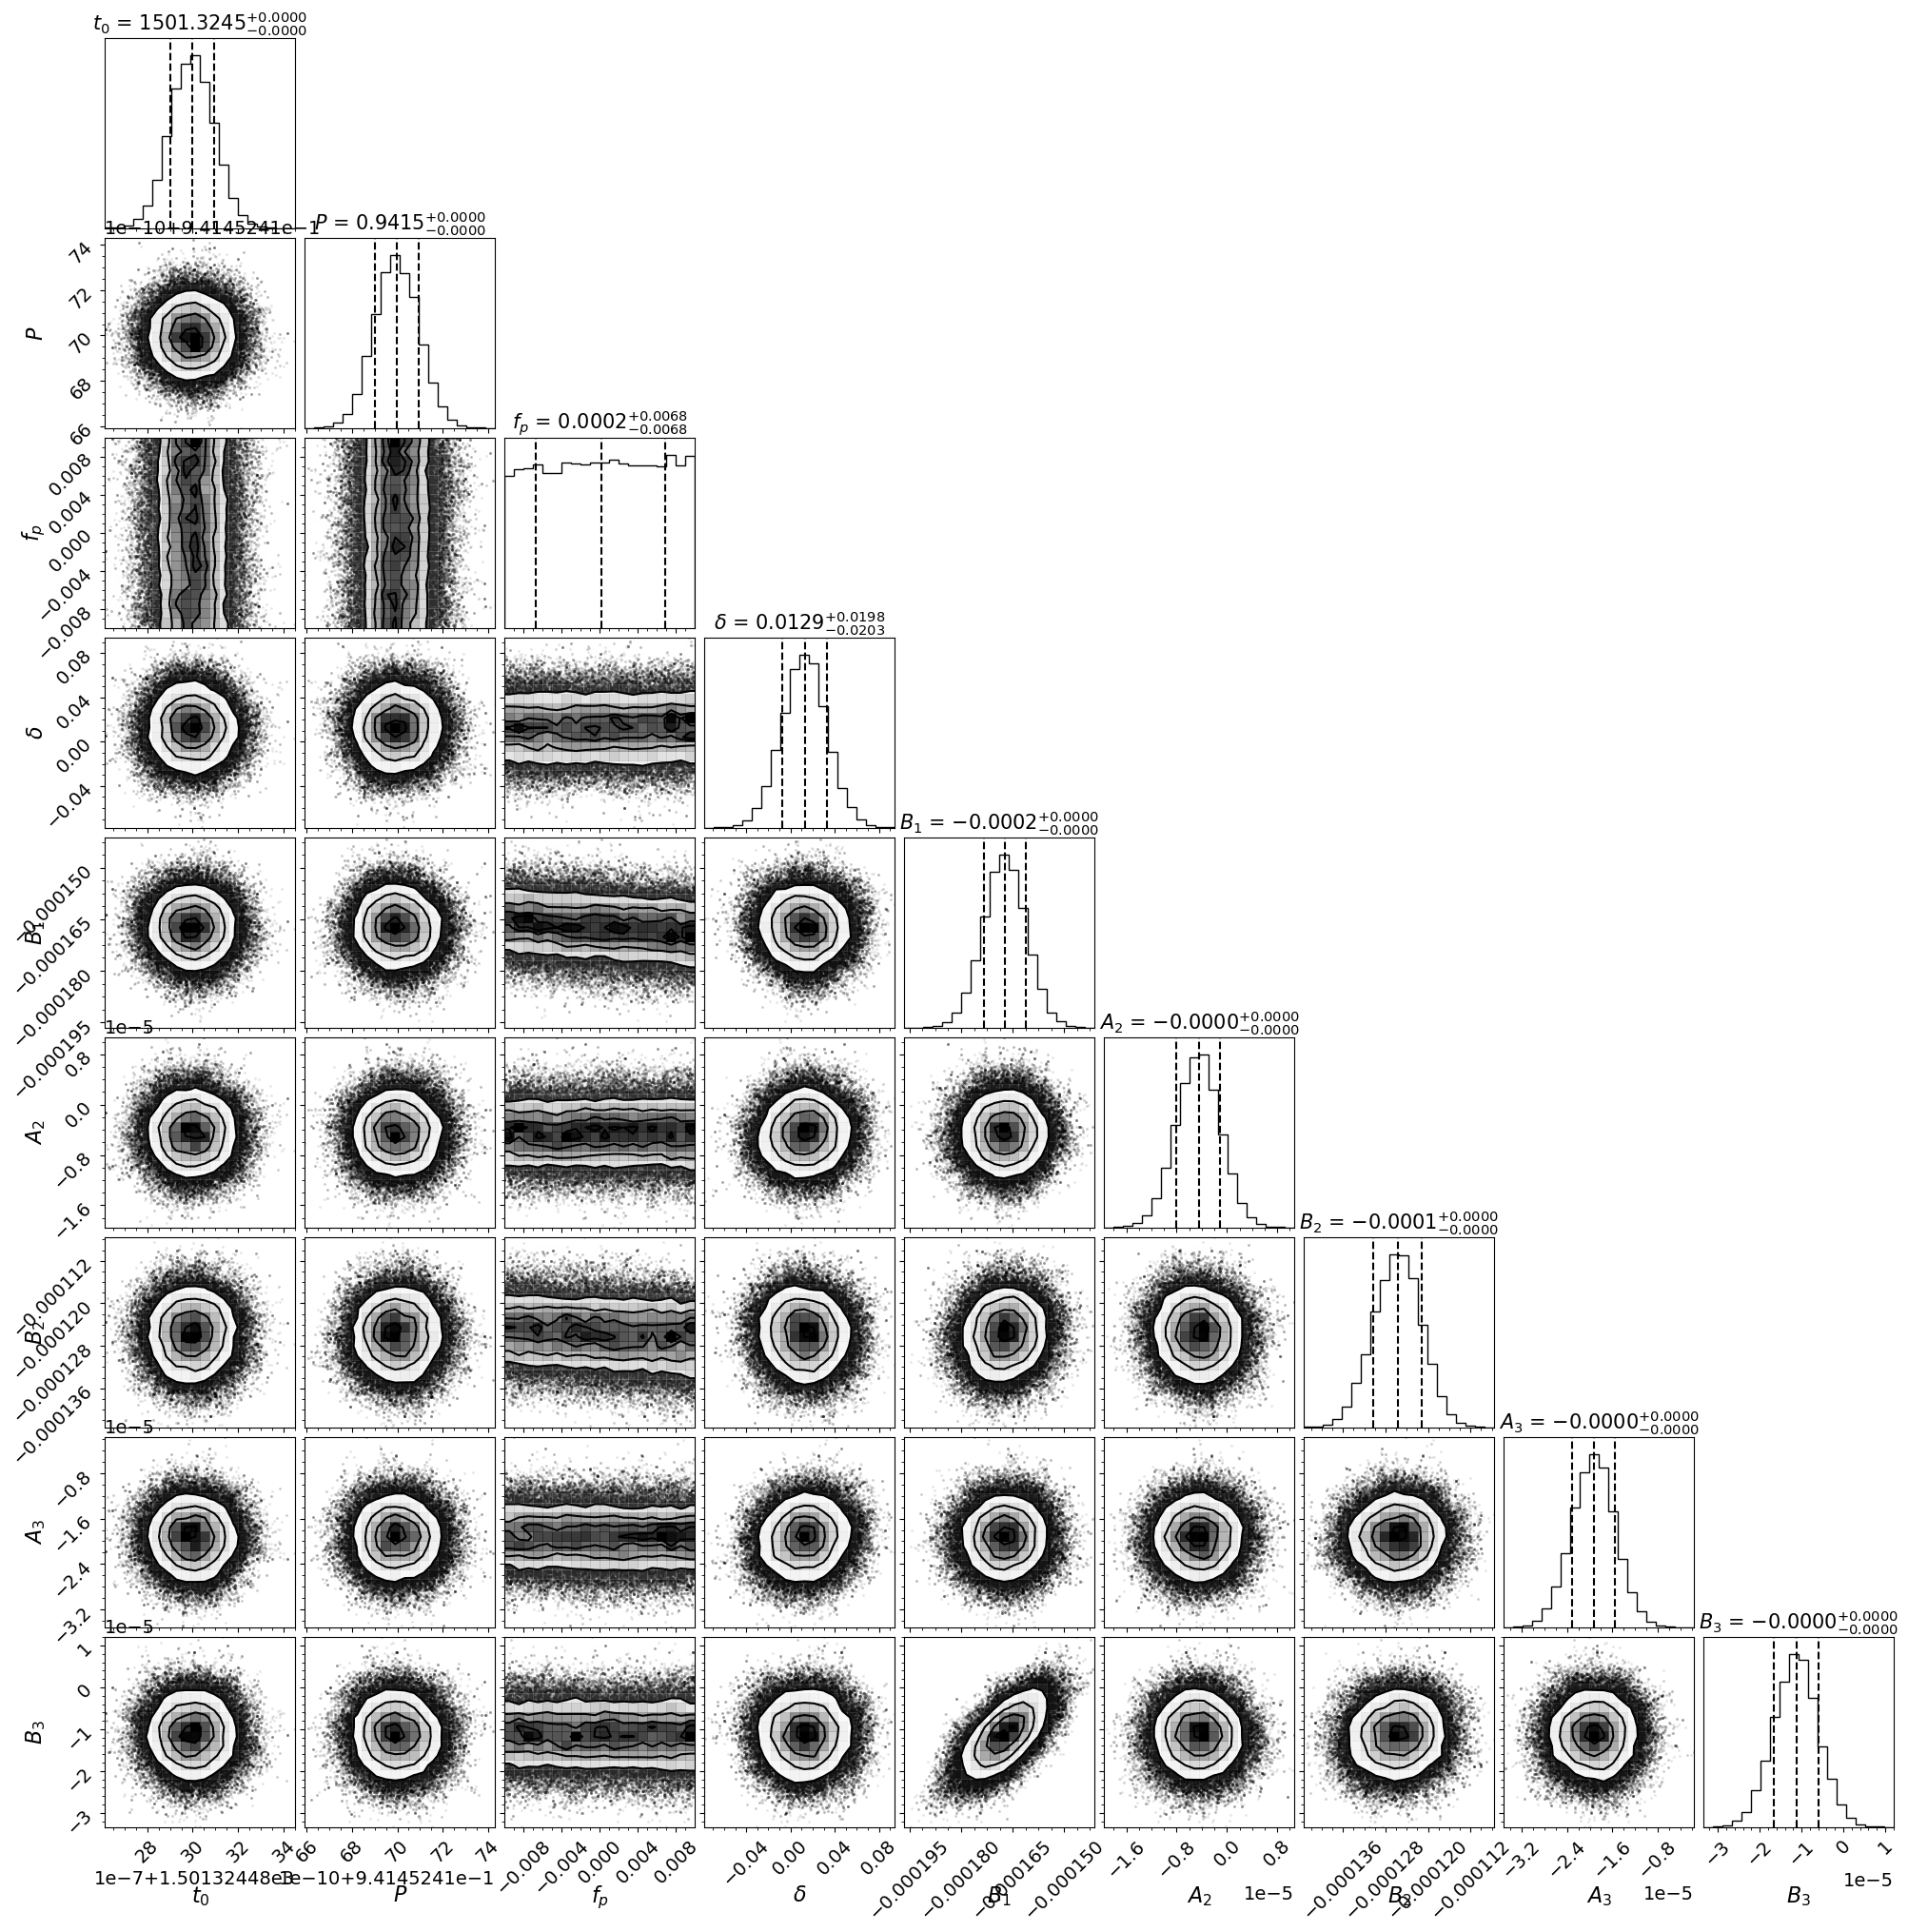

In [194]:
burnin_discard = 3000
chain = sampler.get_chain(flat=True, discard=burnin_discard)
fig = corner.corner(chain, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                        title_kwargs={"fontsize": 15},
                        title_fmt='.4f', label_kwargs={"fontsize": 16})
cornerfig = plt.gcf()
plt.show()
if is_converged == True:
    cornerfig.savefig(corner_dir+planet_name.replace(" ", "")+' Corner Plot '+str(max_n)+' (Converged).png', dpi=300)
if is_converged == False:
    cornerfig.savefig(corner_dir+planet_name.replace(" ", "")+' Corner Plot '+str(max_n)+' (Not Converged).png', dpi=300)

Plot best-fit model overlayed on data

In [75]:
print(P.value)

2.1425095


C:\Users\lucas\TESSPhaseCurves\TESSPhaseCurve_lib.py:192: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
  lc_fold.time_copy = np.copy(lc_fold.time)
C:\Users\lucas\TESSPhaseCurves\TESSPhaseCurve_lib.py:192: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
  lc_fold.time_copy = np.copy(lc_fold.time)


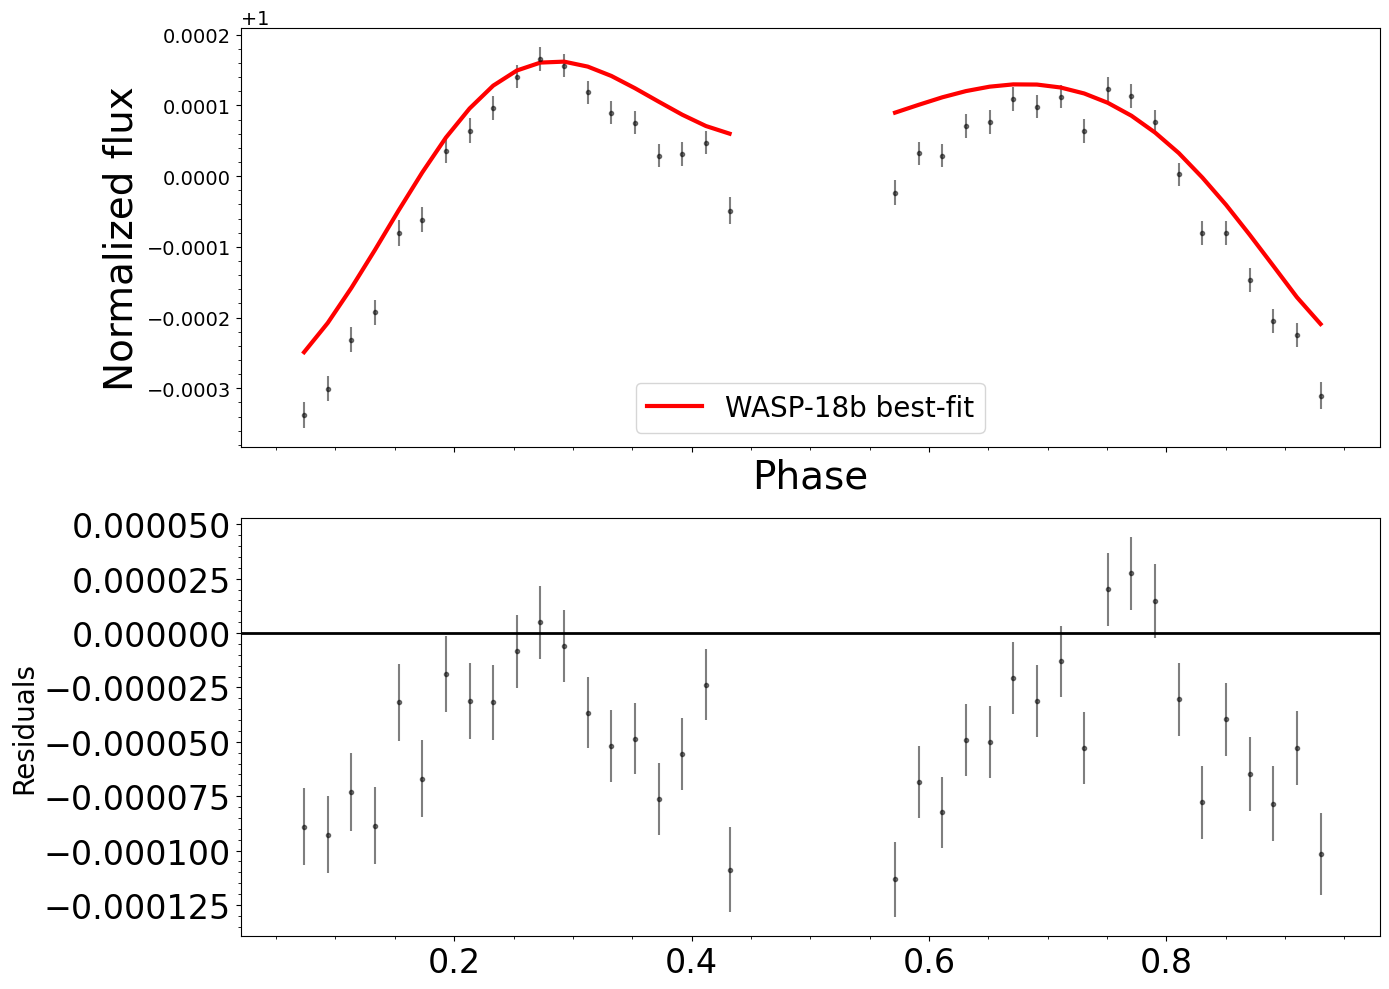

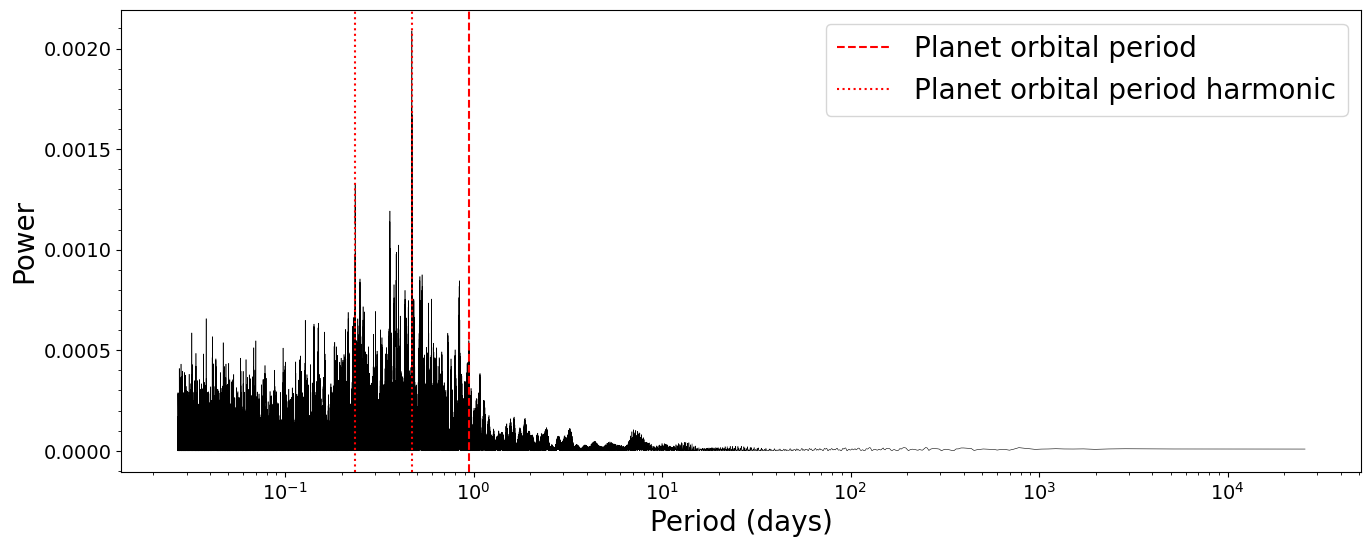

WASP-18b  table successfully saved to  C:\Users\lucas\TESSPhaseCurves/Model Fitting/WASP-18b Fitting/WASP-18b Parameters.xlsx


In [195]:
# Extract best-fit mid-transit time, planet orbital period, and delta
t_0_best, P_best, delta_best = params_best[0]*u.day, params_best[1]*u.day, params_best[3]
# t_0_best, P_best, delta_best = t_0, P, 0

### Compute the model light curve ###
bin_width = (27*u.min).to(u.day)/P_best * u.day
lc_data_fold = TPC.fold_lk(lc_data, P_best, t_0_best)
lc_data_bin = lc_data_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)

# Calculate model and assign to a Lightkurve object
model = psi_tot_noPulse_noA1(params_best, lc_data.time.value)
lc_model = {'time': lc_data.time.value,
           'flux': model,
          }
lc_model = lk.LightCurve(lc_model)
lc_model_fold = TPC.fold_lk(lc_model, P_best, t_0_best)
lc_model_bin = lc_model_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)

# Initialize figure
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 10))#, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})

# Plot data and best fit model
ax1.errorbar(lc_data_bin.time.value, lc_data_bin.flux.value, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5)
ax1.plot(lc_model_bin.time.value, lc_model_bin.flux.value, color='r', linewidth=3, label = planet_name+' best-fit')
ax1.set_ylabel('Normalized flux', fontsize=28)

# Plot residuals
residuals = lc_data_bin.flux.value - lc_model_bin.flux.value
residuals_unbin = lc_data.flux.value - model

residuals_fold = lc_data_fold.flux.value - lc_model_fold.flux.value
ax2.errorbar(lc_data_bin.time.value, residuals, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=1)
ax2.axhline(0, color='k', zorder=0, linewidth=2)
ax1.set_xlabel('Phase', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
ax2.set_ylabel('Residuals')
ax2.set_xlim(0.02, 0.98)

# Formatting
plt.tight_layout()
ax1.legend(fontsize=20)

modelfig = plt.gcf()
plt.show()
if is_converged == True:
    modelfig.savefig(overlay_dir+planet_name.replace(" ", "")+' Model Overlay '+str(max_n)+' (Converged).png', dpi=300)
if is_converged == False:
    modelfig.savefig(overlay_dir+planet_name.replace(" ", "")+' Model Overlay '+str(max_n)+' (Not Converged).png', dpi=300)

# plot periodogram of residuals
nout = 10000
w = np.linspace(1e-4, 4, nout)
time = lc_data.time.value[~np.isnan(residuals_unbin)]
frequency, power = LombScargle(time, residuals_unbin).autopower()

plt.figure(figsize=(16, 6))
plt.plot(1/frequency, power, 'k', linewidth=0.4)
    
plt.axvline(P.value, linestyle='dashed', color='r', label='Planet orbital period')
plt.axvline(P.value/2, linestyle='dotted', color='r', label='Planet orbital period harmonic')
plt.axvline(P.value/4, linestyle='dotted', color='r')

plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.legend(fontsize=20)
plt.show()

# Create and save row of parameters, parameter uncertainty, and result reporting (chi2, max n iterations, and convergence y/n)
table_labels = [r'$t_0$', r'$t_0 +1\sigma$', r'$t_0 -1\sigma$', 
                r'$P$', r'$P +1\sigma$', r'$P -1\sigma$',
                r'$f_p$', r'$f_p +1\sigma$', r'$f_p -1\sigma$', 
                r'$\delta$', r'$\delta +1\sigma$', r'$\delta -1\sigma$', 
                r'$B_1$', r'$B_1 +1\sigma$', r'$B_1 -1\sigma$', 
                r'$A_2$', r'$A_2 +1\sigma$', r'$A_2 -1\sigma$', 
                r'$B_2$', r'$B_2 +1\sigma$', r'$B_2 -1\sigma$', 
                r'$A_3$', r'$A_3 +1\sigma$', r'$A_3 -1\sigma$', 
                r'$B_3$', r'$B_3 +1\sigma$', r'$B_3 -1\sigma$', 
                r'$\chi^2$', r'$BIC$', r'$max n$', r'$Converged?$']

# calculate chi squared
chi2 = chisq_model(lc_data_bin.flux, lc_model_bin.flux, lc_data_bin.flux_err, ndim)

# calculate BIC
param_lnL = TPC.loglike(params_best, lc_data.time.value, lc_data.flux.value, lc_data.flux_err.value, psi_tot_noPulse_noA1) # log probability of params_best
ndata = len(lc_data.flux) # number of data points
bic_value = bic(ndim, ndata, param_lnL) # bayesian information criterion using params_best log probability

# add statistical analysis to parameter table
if is_converged == True:
    results_list = [chi2, bic_value, max_n, "Converged"]
if is_converged == False:
    results_list = [chi2, bic_value, max_n, "Not Converged"]
new_table_row = params_with_err + results_list
planet_table.loc[len(planet_table)] = new_table_row

# save table with new row to excel file
with pd.ExcelWriter(excel_file_path, mode='a', if_sheet_exists='replace', engine='openpyxl') as writer:
    planet_table.to_excel(writer, sheet_name=model_type, header=table_labels, index=False)
print(planet_name, " table successfully saved to ", excel_file_path)

In [175]:
# compare residuals to mean uncertainty
std_residuals = np.nanstd(residuals)
mean_unc = np.nanmean(lc_data_bin.flux_err)
print(std_residuals)
print(mean_unc)
print(std_residuals/mean_unc)

3.524026318782329e-05
1.7044844566797514e-05
2.0675027601289786


C:\Users\lucas\TESSPhaseCurves\TESSPhaseCurve_lib.py:192: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
  lc_fold.time_copy = np.copy(lc_fold.time)
C:\Users\lucas\TESSPhaseCurves\TESSPhaseCurve_lib.py:192: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
  lc_fold.time_copy = np.copy(lc_fold.time)
C:\Users\lucas\TESSPhaseCurves\TESSPhaseCurve_lib.py:192: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/refer

0.00021924434624875921
-0.00028793944290628204


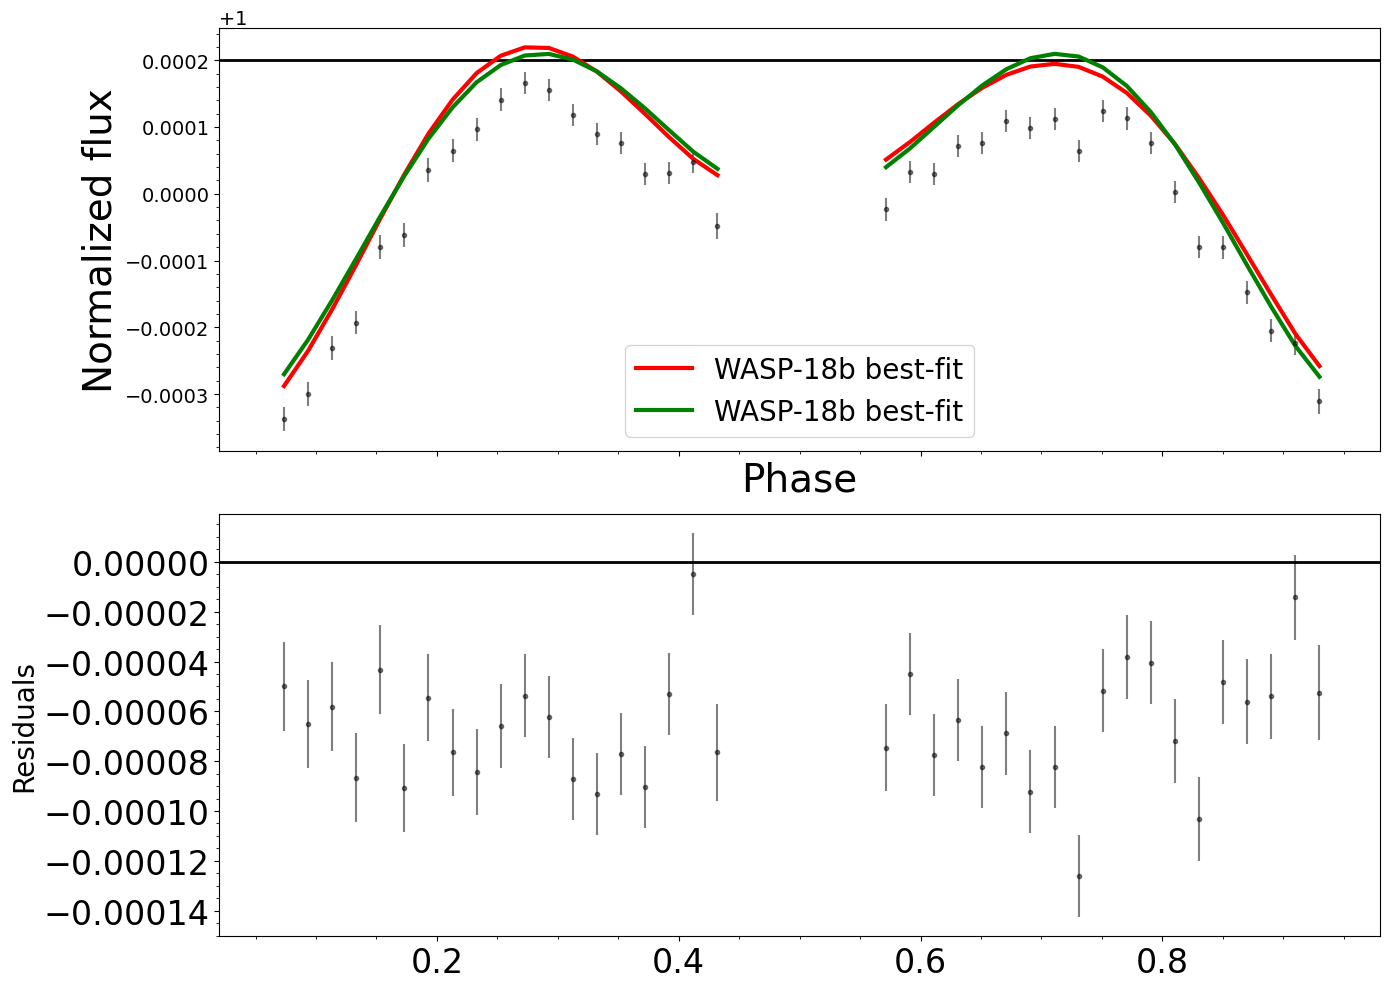

In [222]:
# Test initial values for sampling
t_0_best, P_best = t_0, P

### Compute the model light curve ###
bin_width = (27*u.min).to(u.day)/P_best * u.day
lc_data_fold = TPC.fold_lk(lc_data, P_best, t_0_best)
lc_data_bin = lc_data_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)
max_phase = max(lc_data_bin.flux)
min_phase = min(lc_data_bin.flux)
norm = (max_phase-min_phase)/2

# Calculate model and assign to a Lightkurve object
#             [r'$t_0$',    r'$P$',     r'$f_p$',   r'$\delta$', r'$B_1$',    r'$A_2$',    r'$B_2$',    r'$A_3$',    r'$B_3$']
copy_params_best = np.copy(params_best) # Initial parameter guess
copy_params_best[2] = 0.000341-0.000174
copy_params_best[3] = 0
copy_params_best[4] = -0.000174
copy_params_best[5] = -0.000004
copy_params_best[6] = -0.000190
copy_params_best[7] = -0.000014
copy_params_best[8] = -0.000004
# copy_params_best[4] = -0.000174
# copy_params_best[5] = -0.000004
# copy_params_best[6] = -0.000190
# copy_params_best[7] = -0.000014
# copy_params_best[8] = -0.000004

model = psi_tot_noPulse_noA1(copy_params_best, lc_data.time.value)
lc_model = {'time': lc_data.time.value,
           'flux': model,
          }
lc_model = lk.LightCurve(lc_model)
lc_model_fold = TPC.fold_lk(lc_model, P_best, t_0_best)
lc_model_bin = lc_model_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)



copy_params_best_1 = np.copy(params_best) # Initial parameter guess
copy_params_best_1[2] = 0.000341-0.000174
copy_params_best_1[3] = 0
copy_params_best_1[4] = -0.000174
copy_params_best_1[5] = 0
copy_params_best_1[6] = -0.000190
copy_params_best_1[7] = 0
copy_params_best_1[8] = 0

model_1 = psi_tot_noPulse_noA1(copy_params_best_1, lc_data.time.value)
lc_model_1 = {'time': lc_data.time.value,
           'flux': model_1,
          }
lc_model_1 = lk.LightCurve(lc_model_1)
lc_model_fold_1 = TPC.fold_lk(lc_model_1, P_best, t_0_best)
lc_model_bin_1 = lc_model_fold_1.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)

# Initialize figure
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 10))#, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})

# Plot data and best fit model
ax1.errorbar(lc_data_bin.time.value, lc_data_bin.flux.value, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5)
ax1.plot(lc_model_bin.time.value, lc_model_bin.flux.value, color='r', linewidth=3, label = planet_name+' best-fit')
ax1.axhline(1.0002, color='k', zorder=0, linewidth=2)
ax1.plot(lc_model_bin_1.time.value, lc_model_bin_1.flux.value, color='g', linewidth=3, label = planet_name+' best-fit')
ax1.set_ylabel('Normalized flux', fontsize=28)

# Plot residuals
residuals = lc_data_bin.flux.value - lc_model_bin.flux.value
residuals_fold = lc_data_fold.flux.value - lc_model_fold.flux.value
ax2.errorbar(lc_data_bin.time.value, residuals, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=1)
ax2.axhline(0, color='k', zorder=0, linewidth=2)
ax1.set_xlabel('Phase', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
ax2.set_ylabel('Residuals')
ax2.set_xlim(0.02, 0.98)

# Formatting
plt.tight_layout()
ax1.legend(fontsize=20)

max_model = max(lc_model_bin.flux)
min_model = min(lc_model_bin.flux)
print(max_model-1)
print(min_model-1)

plt.show()

In [198]:
max_model = max(lc_model_bin.flux)
min_model = min(lc_model_bin.flux)
print(max_model-1)
print(min_model-1)

0.0001570876148890843
-0.00015654190214586805


### Perform nested sampling with $\texttt{dynesty}$

In [ ]:
loglike_args = (lc_data.time.value, lc_data.flux.value, lc_data.flux_err.value,
                psi_tot_noPulse_noA1) # loglike function arguments
ptform_args = (priors, priors_bool) # prior_transform function arguments

# Initialize the sampler that will search the parameter space
sampler = DynamicNestedSampler(TPC.loglike, TPC.prior_transform, ndim,
                        logl_args=loglike_args, ptform_args=ptform_args)

# Run the sampler; we define convergence when the estimated contribution of the remaining prior volume to the
# total evidence falls below 1%
filename_root =''.join(planet_name.split())+'_sector'+str(sector)+'_v1' # filename at which to save progress
sampler.run_nested(dlogz_init=0.01, maxiter=100000, checkpoint_file=filename_root+'.save', print_progress=True)

# Save the results from running the sampler
res = sampler.results

# Extract the 50th percentile parameter samples as best fit parameters
params_best = np.array([dynesty.utils.quantile(res.samples[:, i], 0.50, 
                                              weights=res.importance_weights())[0] for i in range(ndim)])

Plot corner plot of posterior distribution

In [ ]:
# Restore sampler
sampler = NestedSampler.restore(''.join(planet_name.split())+'_sector'+str(sector)+'_v1.save')

# Save the results from running the sampler
res = sampler.results

# Extract the 50th percentile parameter samples as best fit parameters
params_best = np.array([dynesty.utils.quantile(res.samples[:, i], 0.50, 
                                              weights=res.importance_weights())[0] for i in range(ndim)])

### Corner plot ###

truths = (P.value, t_0.value, None, None, None, None, None, None, None, None)
# labels = [r'$t_0$', r'$P$',  r'$\Pi$', r'$\alpha$', r'$\beta$', r'$f_p$', r'$\delta$',
#           r'$B_1$', r'$A_2$', r'$B_2$', r'$A_3$', r'$B_3$']
labels = [r'$t_0$', r'$P$',  r'$f_p$', r'$\delta$',
          r'$B_1$', r'$A_2$', r'$B_2$', r'$A_3$', r'$B_3$']

fig, axes = dyplot.cornerplot(res, show_titles=True, title_fmt='0.2e',
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(ndim, ndim, figsize=(30, 30)))

Plot best-fit model overlayed on data

In [ ]:
### Compute the model light curve ###
bin_width = (27*u.min).to(u.day)/P_best * u.day
lc_data_fold = TPC.fold_lk(lc_data, P_best, t_0_best)
lc_data_bin = lc_data_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)

# Extract best-fit mid-transit time, planet orbital period, and delta
t_0_best, P_best, delta_best = params_best[0]*u.day, params_best[1]*u.day, params_best[6]

# Calculate model and assign to a Lightkurve object
model = psi_tot_noA1(params_best, lc_data.time.value)
lc_model = {'time': lc_data.time.value,
           'flux': model,
          }
lc_model = lk.LightCurve(lc_model)
lc_model_fold = TPC.fold_lk(lc_model, P_best, t_0_best)
lc_model_bin = lc_model_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)

# Initialize figure
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 10))#, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})

# Plot data and best fit model
ax1.errorbar(lc_data.time.value, lc_data.flux.value, lc_data.flux_err.value, fmt='.', color='k', alpha=0.5)
ax1.plot(lc_model.time.value, lc_model.flux.value, color='r', linewidth=3, label='TOI-1518 b best-fit')
ax1.set_ylabel('Normalized flux', fontsize=28)
ax1.set_xlim(2750, 2800)

# Plot residuals
residuals = lc_data_bin.flux.value - lc_model_bin.flux.value
# residuals_fold = lc_data_fold.flux.value - lc_model_fold.flux.value
# ax2.errorbar(lc_data_bin.time.value, residuals, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=1)
# ax2.axhline(0, color='k', zorder=0, linewidth=2)
# ax1.set_xlabel('Phase', fontsize=28)
# plt.xticks(fontsize=24)
# plt.yticks(fontsize=24)
# ax2.set_ylabel('Residuals')
# ax2.set_xlim(0.02, 0.98)

# Formatting
plt.tight_layout()
ax1.legend(fontsize=20)
plt.show()

Example of model fitting

In [ ]:
### Compute the model light curve ###

# Extract best-fit mid-transit time, planet orbital period, and delta
t_0_best, P_best, delta_best = params_best[0]*u.day, params_best[1]*u.day, params_best[6]

# Calculate model and assign to a Lightkurve object
model = psi_tot_noA1(params_best, lc_data.time.value)
lc_model = {'time': lc_data.time.value,
           'flux': model,
          }
lc_model = lk.LightCurve(lc_model)

params_east = np.hstack([params_best[0:2], params_best[5:]])
params_east[3] = 10 * np.pi/180
east = psi_tot_noPulse_noA1(params_east, lc_data.time.value)
lc_east = {'time': lc_data.time.value,
           'flux': east,
          }
lc_east = lk.LightCurve(lc_east)

params_west = np.hstack([params_best[0:2], params_best[5:]])
params_west[3] = -10 * np.pi/180
west = psi_tot_noPulse_noA1(params_west, lc_data.time.value)
lc_west = {'time': lc_data.time.value,
           'flux': west,
          }
lc_west = lk.LightCurve(lc_west)

# Phase fold and bin data and model
# bin_width = (9*u.min).to(u.day)/P_best * u.day
bin_width = (27*u.min).to(u.day)/P_best * u.day
lc_data_fold = TPC.fold_lk(lc_data, P_best, t_0_best)
lc_data_bin = lc_data_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)
lc_model_fold = TPC.fold_lk(lc_model, P_best, t_0_best)
lc_model_bin = lc_model_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)
lc_east_fold = TPC.fold_lk(lc_east, P_best, t_0_best)
lc_east_bin = lc_east_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)
lc_west_fold = TPC.fold_lk(lc_west, P_best, t_0_best)
lc_west_bin = lc_west_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)

chisq_model = np.nansum(((lc_data_bin.flux - lc_model_bin.flux)**2)/(lc_data_bin.flux_err**2))/(len(lc_data_bin)-ndim)
chisq_east = np.nansum(((lc_data_bin.flux - lc_east_bin.flux)**2)/(lc_data_bin.flux_err**2))/(len(lc_data_bin)-ndim)
chisq_west = np.nansum(((lc_data_bin.flux - lc_west_bin.flux)**2)/(lc_data_bin.flux_err**2))/(len(lc_data_bin)-ndim)

chisq_text_model = r'$\chi^2_\nu = '+str(round(chisq_model.value, 2))+'$'
chisq_text_east = r'$\chi^2_\nu = '+str(round(chisq_east.value, 2))+'$'
chisq_text_west = r'$\chi^2_\nu = '+str(round(chisq_west.value, 2))+'$'

# Initialize figure
fig, ax1 = plt.subplots(1, sharex=True, figsize=(14, 6))#, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})

# Plot data and best fit model
ax1.errorbar(lc_data_bin.time.value, lc_data_bin.flux.value, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5)
# ax1.scatter(lc_data_fold.time.value, lc_data_fold.flux.value, marker='.', color='k', alpha=0.05)
ax1.plot(lc_model_bin.time.value, lc_model_bin.flux.value, color='k', linewidth=3, label='TOI-1518 b best-fit')
ax1.plot(lc_east_bin.time.value, lc_east_bin.flux.value, color='blue', label=r'10$^\circ$ eastward hotspot offset')
ax1.plot(lc_west_bin.time.value, lc_west_bin.flux.value, color='red', label=r'10$^\circ$ westward hotspot offset')
ax1.set_ylabel('Normalized flux', fontsize=28)
ax1.set_xlim(0.02, 0.98)
ax1.set_ylim(1-0.00029, 1+0.00029)


ax1.annotate('', xy=(0.5, 1.00022), xytext=(0.4, 1.00022),
            fontsize=18, color='blue', arrowprops=dict(arrowstyle="<-", color='blue'))
ax1.annotate('', xy=(0.5, 1.00022), xytext=(0.6, 1.00022),
            fontsize=18, color='red', arrowprops=dict(arrowstyle="<-", color='red'))
ax1.text(0.4, 1.000235, 'East', color='blue', fontsize=28)
ax1.text(0.5, 1.000235, 'West', color='red', fontsize=28)

ax1.text(0.8, 1.000235, chisq_text_model, color='k', fontsize=24)
ax1.text(0.8, 1.00017, chisq_text_east, color='blue', fontsize=24)
ax1.text(0.8, 1.000105, chisq_text_west, color='red', fontsize=24)
# ax1.text(0.5-10./360, 1.0003, 'East', fontsize=18)


# # Plot residuals
# residuals = lc_data_bin.flux.value - lc_model_bin.flux.value
# residuals_fold = lc_data_fold.flux.value - lc_model_fold.flux.value
# ax2.errorbar(lc_data_bin.time.value, residuals, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=1)
# # ax2.scatter(lc_data_fold.time.value, residuals_fold, marker='.', color='k', alpha=0.05)
# ax2.axhline(0, color='k', zorder=0, linewidth=2)
ax1.set_xlabel('Phase', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# ax2.set_ylabel('Residuals')
# ax2.set_xlim(0.02, 0.98)

# Formatting
plt.tight_layout()
ax1.legend(fontsize=20)
plt.savefig('../TOI-1518b.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print(params_best)